In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    ## Let's shift each signal so that reference time matches for each signal
    mean_ref_time = int(y.mean())
    X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])
    y = np.array([mean_ref_time]*len(y))

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [3]:
X_origin, y_origin = get_data()

mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [4]:
def get_ref_time(first_impulse, second_impulse, first_ref_time, second_ref_time):
    if np.min(first_impulse) < np.min(second_impulse):
         return first_ref_time
    else:
        return second_ref_time

In [5]:
import random

def generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    first_ref_time = y_origin[first_idx]
    second_ref_time = y_origin[second_idx]
    
    
#     print("SHIFT:", tau)
#     print("BEFORE SHIFT:", first_ref_time, second_ref_time)
    ### Randomly choose what signal to shift
#     if random.choice([True, False]):
#         first_impulse = signal_cyclic_shift(first_impulse, tau)
#         first_ref_time += tau
#     else:
#         second_impulse = signal_cyclic_shift(second_impulse, tau)
#         second_ref_time += tau
    second_impulse = signal_cyclic_shift(second_impulse, tau)
    second_ref_time += tau
    
#     print("AFTER SHIFT:", first_ref_time, second_ref_time)
    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

#     print(mean_argmin - np.argmin(multi_impulse))
    first_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    second_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    
    if to_plot:
        plt.plot(first_impulse)
        plt.plot(second_impulse)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    ref_time = get_ref_time(first_impulse, second_impulse*alpha, first_ref_time, second_ref_time)
    
    return {'first_impulse': first_impulse_shifted,\
            'second_impulse': second_impulse_shifted,\
            'ref_time': ref_time,\
            'multi_impulse': multi_impulse_shifted}

In [6]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['ref_time']) 
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [7]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


tau_range = list(map(int, get_truncated_normal(mean=0, sd=10, low=-40, upp=40).rvs(1000)))
alpha_range = np.array([0.01, 0.05, 0.1, 0.5, 1])
freq_values = [1, 25, 50, 75, 100, 125, 150, 175, 200]

In [8]:
import xgboost as xgb
from sklearn.model_selection import cross_validate
from math import sqrt

In [9]:
results = {alpha: [] for alpha in alpha_range}

In [10]:
TIME_SCALE_COEF = 0.2
DATA_SIZE = 2000

model = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)

for alpha in alpha_range:
    X_cur, y_cur = prepare_data(X_origin, y_origin, tau_range, [alpha], data_size=DATA_SIZE)
    for freq in tqdm.tqdm(freq_values):
        X_freq = get_freq_data(X_cur, freq=freq)
        scoring = ['neg_mean_squared_error']
        scores = cross_validate(model, X_freq, y_cur, scoring=scoring, cv=5)
        results[alpha].append(sqrt(-scores['test_neg_mean_squared_error'].mean() * TIME_SCALE_COEF))

100%|██████████| 9/9 [01:34<00:00, 10.44s/it]


In [11]:
one_signal_results = []

In [12]:
file = open('./data/shashlik_61_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])

X = data[:, 2:]
y_baseline = data[:, 1]
y = data[:, 0]


X = np.array([experiment - np.max(experiment) for experiment in X])
X = np.array([experiment/-np.min(experiment) for experiment in X])

y = np.round(y)
y = y.astype(int)

In [13]:
idx = np.random.choice(np.arange(len(X_origin)), DATA_SIZE, replace=False)
X_cur = X[idx]
y_cur = y[idx]

for freq in tqdm.tqdm(freq_values):
    X_freq = get_freq_data(X_cur, freq=freq, start_point=355)
    scoring = ['neg_mean_squared_error']
    scores = cross_validate(model, X_freq, y_cur, scoring=scoring, cv=5)
    one_signal_results.append(-scores['test_neg_mean_squared_error'].mean() * TIME_SCALE_COEF)

100%|██████████| 9/9 [01:30<00:00, 10.06s/it]


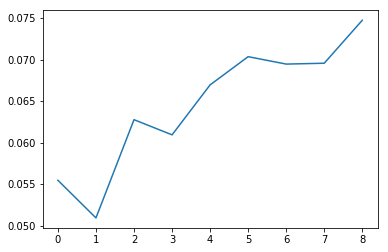

In [14]:
plt.plot(one_signal_results)

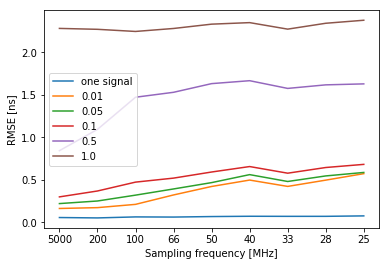

In [15]:
plt.plot(one_signal_results)

for alpha in results.keys():
    plt.plot(results[alpha])

    
ORIGIN_FREQ = 5000
plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(['one signal'] + list(results.keys()))
plt.show()